In [2]:
pip install ucimlrepo

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from ucimlrepo import fetch_ucirepo

dataset = fetch_ucirepo(id=235)
df = dataset.data.features.copy()
print(df)

/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


               Date      Time Global_active_power Global_reactive_power  \
0        16/12/2006  17:24:00               4.216                 0.418   
1        16/12/2006  17:25:00               5.360                 0.436   
2        16/12/2006  17:26:00               5.374                 0.498   
3        16/12/2006  17:27:00               5.388                 0.502   
4        16/12/2006  17:28:00               3.666                 0.528   
...             ...       ...                 ...                   ...   
2075254  26/11/2010  20:58:00               0.946                   0.0   
2075255  26/11/2010  20:59:00               0.944                   0.0   
2075256  26/11/2010  21:00:00               0.938                   0.0   
2075257  26/11/2010  21:01:00               0.934                   0.0   
2075258  26/11/2010  21:02:00               0.932                   0.0   

         Voltage Global_intensity Sub_metering_1 Sub_metering_2  \
0        234.840           18.40

In [13]:
# Step 2: Combine 'Date' and 'Time' (only if they exist)
if 'Date' in df.columns and 'Time' in df.columns:
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
    df.set_index('datetime', inplace=True)
    df.drop(columns=['Date', 'Time'], inplace=True)
elif 'datetime' in df.index.names:
    print("Datetime already set.")
else:
    raise ValueError("Neither 'Date' and 'Time' nor 'datetime' column available.")

# Step 3: Replace "?" and empty strings with NaN
df.replace("?", np.nan, inplace=True)

# Step 4: Convert numeric columns to proper float types
numeric_columns = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
df[numeric_columns] = df[numeric_columns].astype(float)

# Step 5: Drop rows with missing values
df.dropna(inplace=True)

# Step 6: Resample to hourly data using lowercase 'h'
df_hourly = df.resample('h').mean()

# Step 7: Drop rows where target is NaN after resampling
df_hourly = df_hourly.dropna(subset=['Global_active_power'])

print(df)


                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

           

In [14]:
# Step 8: Add time-based features
df_hourly['hour'] = df_hourly.index.hour
df_hourly['dayofweek'] = df_hourly.index.dayofweek
df_hourly['month'] = df_hourly.index.month
df_hourly['is_weekend'] = df_hourly['dayofweek'].isin([5, 6]).astype(int)

# Step 9: Define features and target
features = [
    'Voltage', 'Global_reactive_power', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'hour', 'dayofweek', 'month', 'is_weekend'
]
target = 'Global_active_power'

X = df_hourly[features]
y = df_hourly[target]

# Optional: Drop any remaining NaNs in X or y (just in case)
X = X.dropna()
y = y[X.index]  # Align y with filtered X

print(X)
print(y)

                        Voltage  Global_reactive_power  Global_intensity  \
datetime                                                                   
2006-12-16 17:00:00  234.643889               0.229000         18.100000   
2006-12-16 18:00:00  234.580167               0.080033         15.600000   
2006-12-16 19:00:00  233.232500               0.085233         14.503333   
2006-12-16 20:00:00  234.071500               0.075100         13.916667   
2006-12-16 21:00:00  237.158667               0.076667         13.046667   
...                         ...                    ...               ...   
2010-11-26 17:00:00  237.069667               0.061400          7.216667   
2010-11-26 18:00:00  237.531833               0.053700          6.620000   
2010-11-26 19:00:00  236.741000               0.060033          7.056667   
2010-11-26 20:00:00  239.396000               0.061167          4.913333   
2010-11-26 21:00:00  239.690000               0.000000          3.800000   

           

In [15]:
# Step 10: Train-test split (no shuffle for time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Step 11: Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 12: Predictions
y_pred = model.predict(X_test)

print(y_pred)

[0.37977633 0.98415533 1.95523333 ... 1.669264   1.15433633 0.90139   ]


In [20]:
# Step 13: Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluation Metrics:")
print(f"RMSE: {rmse:.4f} kW")
print(f"MAE: {mae:.4f} kW")
print(f"R² Score: {r2:.4f}")

Evaluation Metrics:
RMSE: 0.0208 kW
MAE: 0.0126 kW
R² Score: 0.9992


/tmp/ipython-input-2159853275.py:9: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


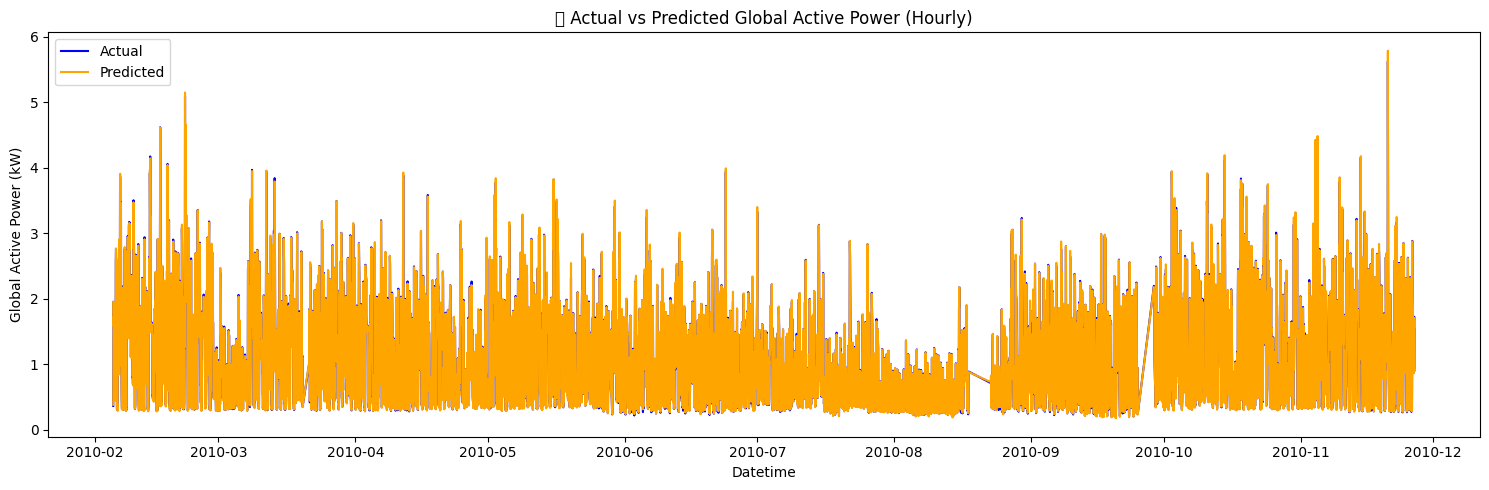

In [17]:
# Step 14: Plot actual vs predicted
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linewidth=1.5)
plt.plot(y_test.index, y_pred, label='Predicted', color='orange', linewidth=1.5)
plt.title('📉 Actual vs Predicted Global Active Power (Hourly)')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

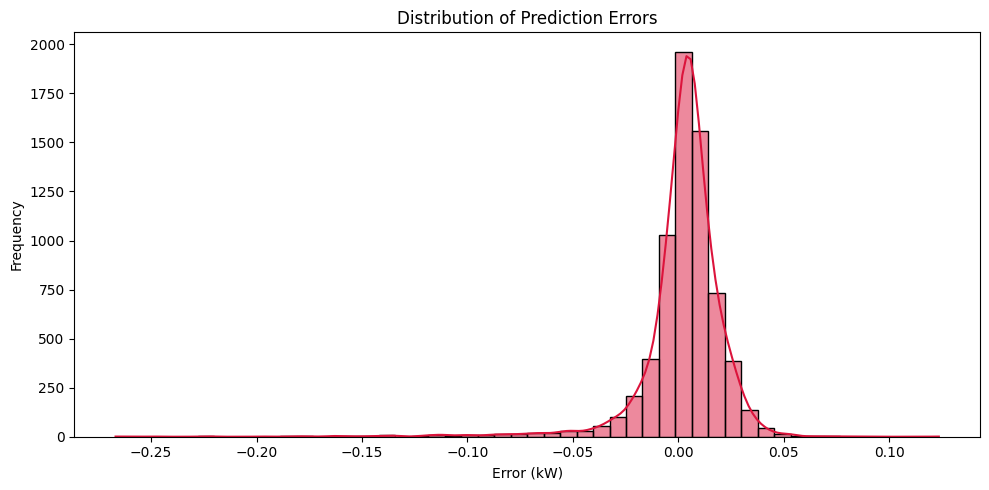

In [18]:
# Step 15: Error distribution
errors = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(errors, bins=50, kde=True, color='crimson')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (kW)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()